# UZOP - timski projekt
Hrvoje Molnar (0036534711)

Ana Francesca Stama (JMBAG)

Luka Nestić (JMBAG)


In [473]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import is_numeric_dtype
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.metrics import accuracy_score, f1_score,precision_score,recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

Prvo, replicirat ćemo rezultate polaznog članka. Počinjemo s čišćenjem dobivenih podataka.

# Predobrada podataka

In [475]:
df=pd.read_csv("CBWDB.csv")
df

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1795,BPL,26.0,NaN,NaN,0.0,3.0,39.0,40.0,110.0,78.0,112.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1796,BPL,22.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1797,BPL,24.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798,BPL,24.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vidimo da u ciljnom stupcu LNH ima nedostajućih vrijednosti. Morat ćemo ukloniti takve točke jer njihova nadopuna nema smisla. Ne možemo u klasifikacijskom problemu mijenjati ciljne klase.

In [476]:
df_filtered=df[df["LNH"].isna()==False]
print("Nedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())
print("\nBroj redaka nakon filtriranja: ",len(df_filtered))

Nedostajuće vrijednosti po stupcima:
SEC             200
Age(years)        3
Height(cm)      128
Bgroup          367
Parity            0
ANC               0
Iwt(kg)          12
FWt(kg)          13
IBP_sys           4
IBP_dias          4
FBP_sys           6
FBP_dias          6
IHb(gm%)        103
FHb(gm%)        102
BS(RBS)         531
Term/Preterm    133
Sex              11
BWt(kg)           0
LNH               0
dtype: int64

Broj redaka nakon filtriranja:  1072


U datasetu vidimo da preko pola vrijednosti BS(RBS) nedostaje! Procjenjujemo da uklanjanjem redova s nepostojećim vrijednostima ove varijable možemo doći do približnog broja filtriranih podataka u članku (445) pa ćemo tako i postupiti. Usput ćemo ukloniti i točke s marginalnim vrijednostima: LNH vrijednosti 3 (pretila novorođenčad) i Sex u vrijednosti T. Takvih je podataka vrlo, vrlo malo pa brojem redova sigurno nećemo pasti ispod okvirnih 445 redaka dataframea.


In [477]:
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T") & (df_filtered["BS(RBS)"].isna()==False)] 

print(df_filtered.isna().sum())
print("Broj točaka: ",len(df_filtered))

SEC             35
Age(years)       0
Height(cm)       0
Bgroup          20
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     2
Sex              1
BWt(kg)          0
LNH              0
dtype: int64
Broj točaka:  537


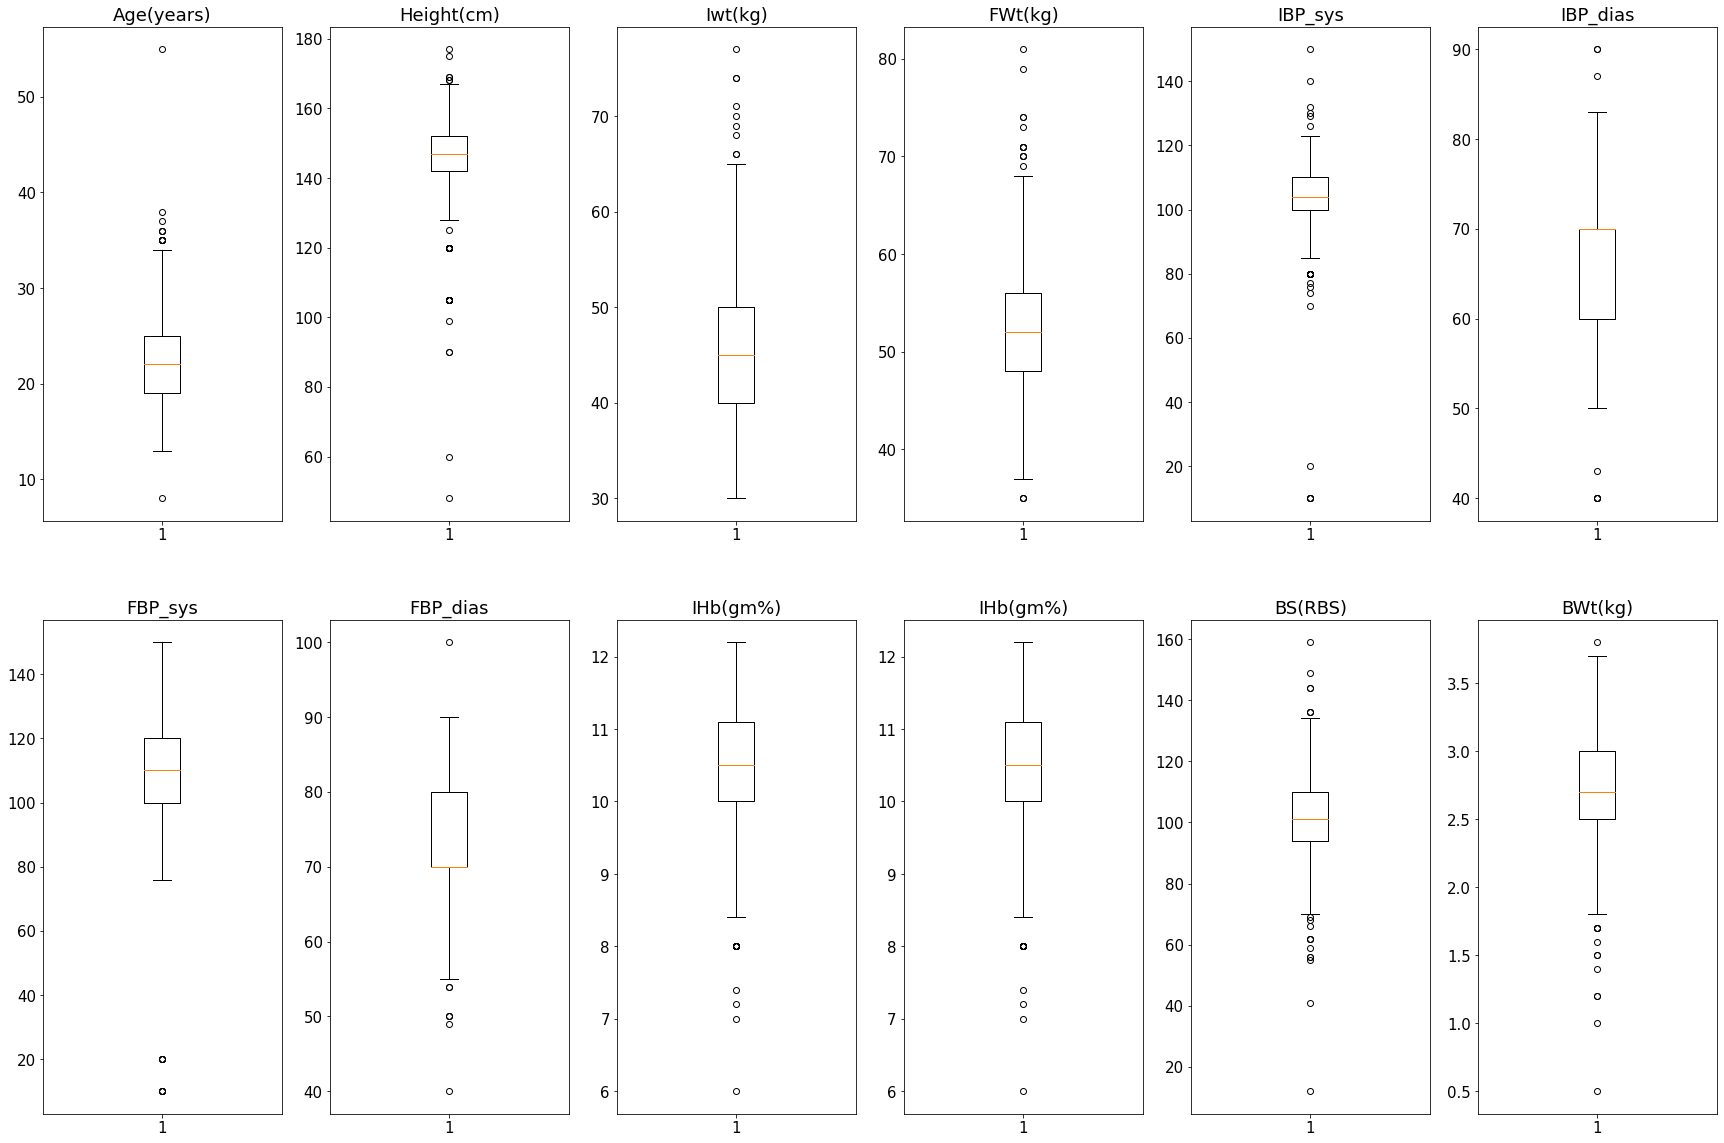

In [478]:
cols=["Age(years)","Height(cm)","Iwt(kg)","FWt(kg)","IBP_sys","IBP_dias","FBP_sys","FBP_dias","IHb(gm%)","IHb(gm%)","BS(RBS)","BWt(kg)"]
fig,ax=plt.subplots(2,6,figsize=(30,20))
i,j=0,0
for col in cols:
    if col not in cat_cols:
        ax[i,j].boxplot(df_filtered[col])
        ax[i,j].set_title(col)
        j+=1
        if j==6:
            i,j=i+1,0
        

U datasetu postoje problemi stršećih uzoraka. Uklonit ćemo i te podatke.

In [ ]:
#Q3=-Q1=0.675 => IQR=1.35 => Q3+1.5*IQR=2.7

print('Broj zapisa prije izbacivanja outliera:', len(df_filtered))
df_copy = df_filtered.copy()

for col in df_copy.columns:
    if is_numeric_dtype(df_copy[col]):
        z = np.abs(stats.zscore(df_copy[col]))
        outlier_indices = np.where(z > 2.7)[0]
        df_copy = df_copy.drop(df_copy.index[outlier_indices])

df_filtered=df_copy.copy()
print('Broj zapisa nakon izbacivanja outliera:', len(df_copy))
print("\nNedostajuće vrijednosti po stupcima:")
print(df_filtered.isna().sum())

Broj zapisa prije izbacivanja outliera: 537
Broj zapisa nakon izbacivanja outliera: 421

Nedostajuće vrijednosti po stupcima:
SEC             22
Age(years)       0
Height(cm)       0
Bgroup          16
Parity           0
ANC              0
Iwt(kg)          0
FWt(kg)          0
IBP_sys          0
IBP_dias         0
FBP_sys          0
FBP_dias         0
IHb(gm%)         0
FHb(gm%)         0
BS(RBS)          0
Term/Preterm     0
Sex              1
BWt(kg)          0
LNH              0
dtype: int64


Sve NaN vrijednosti pripadaju kategoričkim varijablama. Pošto ih je relativno malo, zamijenit ćemo ih modom pripadajućeg stupca.

In [480]:
cat_cols=["SEC","Sex","Term/Preterm","Bgroup"]
for col in cat_cols:
    df_filtered[col]=df_filtered[col].fillna(df_filtered[col].mode()[0])

Za kraj, kategoričke značajke pretvaramo u numeričke, a numeričke normaliziramo. Nakon cijelog postupka, ostaje nam 421 uzorak, malo manje nego u članku.

In [481]:
for col in df_filtered.columns:
    if col in cat_cols:
        df_filtered[col]=df_filtered[col].astype('category').cat.codes
    else:
        df_filtered[col]=(df_filtered[col]-df_filtered[col].min())/(df_filtered[col].max()-df_filtered[col].min())

df_filtered

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,1,0.476190,0.456140,1,0.5,1.0,0.117647,0.071429,0.724138,0.756757,0.594595,0.500,0.476190,1.000000,0.378378,1,0,0.500000,1.0
2,1,0.523810,0.614035,4,0.5,0.5,0.558824,0.535714,0.293103,0.054054,0.459459,0.500,0.714286,0.659574,0.540541,1,1,0.363636,0.0
3,1,0.285714,0.596491,5,0.5,0.0,0.558824,0.357143,0.275862,0.054054,0.324324,0.250,0.476190,0.446809,0.554054,1,0,0.454545,1.0
4,1,0.380952,0.526316,5,0.5,1.0,0.323529,0.285714,0.448276,0.270270,0.459459,0.500,0.238095,0.361702,0.500000,1,0,0.318182,0.0
5,1,0.285714,0.526316,6,0.0,1.0,0.411765,0.500000,0.448276,0.540541,0.594595,0.750,0.238095,0.276596,0.418919,1,0,0.409091,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,1,0.714286,0.385965,5,0.5,1.0,0.352941,0.285714,0.448276,0.432432,0.378378,0.475,0.452381,0.531915,0.729730,1,1,0.636364,1.0
1589,1,0.809524,0.438596,5,0.5,0.5,0.676471,0.607143,0.603448,0.378378,0.621622,0.650,0.547619,0.446809,0.729730,0,1,0.409091,1.0
1600,1,0.428571,0.526316,4,0.0,1.0,0.647059,0.642857,0.517241,0.567568,0.351351,0.275,0.119048,0.531915,0.337838,1,1,0.727273,1.0
1607,1,0.428571,0.298246,4,0.0,1.0,0.382353,0.285714,0.517241,0.324324,0.432432,0.300,0.476190,0.468085,0.135135,1,0,0.636364,1.0


# Vizualizacija

Kako bismo dobili uvid u strukturu podataka te moguće probleme, provodimo analizu glavnih komponenti (PCA). PCA je tehnika za smanjenje dimenzionalnosti podataka koja pronalazi osi najveće varijabilnosti podataka te preslikava $n$-dimenzionalni prostor podataka u $k$-dimenzionalni, gdje $n>k$. Kao takva, vezana je uz varijance naših značajki.

In [482]:
#Pretvorba u ndarray i train-test podjela s uključenom stratifikacijom
X=df_filtered.drop(columns="LNH").to_numpy()
y=df_filtered["LNH"].to_numpy()

print("Column variances: \n",np.var(X,axis=0))

Column variances: 
 [0.19854323 0.03042766 0.02741951 2.5556615  0.08131019 0.061044
 0.02922874 0.04442437 0.02571426 0.03856301 0.01815431 0.03468056
 0.04593368 0.02978496 0.03243216 0.09732511 0.24949081 0.03084121]


Vidimo da je $Var(\text{Bgroup})$ puno veća od ostalih (četvrta vrijednost). Pogledajmo kako izgleda dvodimenzionalna PCA preslika podataka s i bez tog stupca.

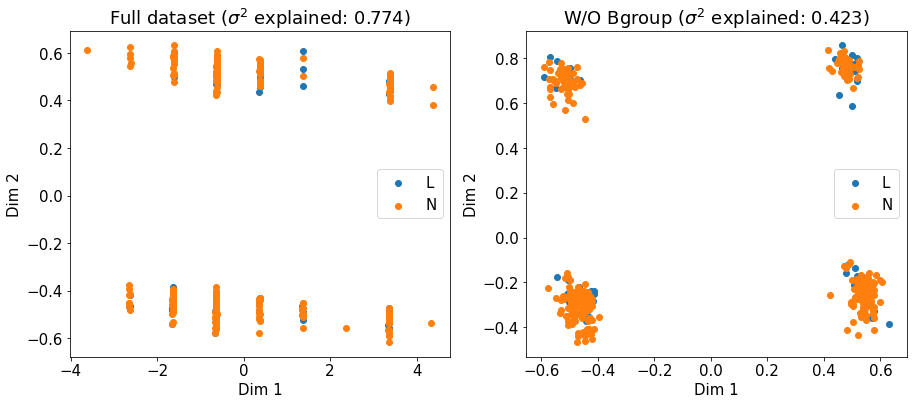

In [483]:
pca=PCA(n_components=2)
fig,ax=plt.subplots(1,2,figsize=(15,6))

X_pca1=pca.fit_transform(X)
ax[0].scatter(X_pca1[np.where(y==0)[0], 0], X_pca1[np.where(y==0)[0], 1], label="L")
ax[0].scatter(X_pca1[np.where(y==1)[0], 0], X_pca1[np.where(y==1)[0], 1], label="N")
ax[0].set_title("Full dataset ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[0].set_xlabel("Dim 1")
ax[0].set_ylabel("Dim 2")
ax[0].legend()

X_pca2=pca.fit_transform(np.delete(X,3,axis=1))
ax[1].scatter(X_pca2[np.where(y==0)[0], 0], X_pca2[np.where(y==0)[0], 1], label="L")
ax[1].scatter(X_pca2[np.where(y==1)[0], 0], X_pca2[np.where(y==1)[0], 1], label="N")
ax[1].set_title("W/O Bgroup ($\sigma^2$ explained: {:.3f})".format(sum(pca.explained_variance_ratio_)))
ax[1].set_xlabel("Dim 1")
ax[1].set_ylabel("Dim 2")
ax[1].legend()

plt.show()

Ovdje imamo dva komentara. Prvo, klase nisu razdvojene ni na jednom grafu (t-SNE vizualizacija i micanje ostalih značajki s visokom varijancom to ne mijenjaju). To nam govori da će klasifikacija vrlo vjerojatno biti teška. Drugo, micanjem Bgroup stupca, objašnjenja varijanca smanjena je za 45%! Vidimo da je Bgroup veliki faktor za opisivanje podataka. Međutim, sjećamo se da je bilo jako puno nedostajućih vrijednosti u polaznom datasetu (367/1072 redova kojima LNH nije NaN $\approx$ 34%). Također, korelacija između tog stupca i BWt(kg) je skoro zanemariva:

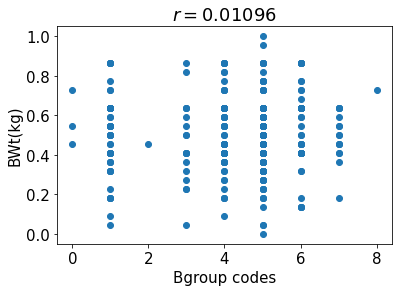

In [484]:
plt.scatter(df_filtered["Bgroup"],df_filtered["BWt(kg)"])
plt.xlabel("Bgroup codes")
plt.ylabel("BWt(kg)")
plt.title("$r=${:.5f}".format(np.corrcoef(df_filtered["Bgroup"],df_filtered["BWt(kg)"])[0,1]))
plt.show()

Iz problema velikog broja NaN vrijednosti i nepostojeće koreliranosti zaključujemo da se stupac Bgroup može ukloniti iz skupa podataka. To ćemo napraviti tek kasnije pri poboljšanju rezultata članka. Sad možemo krenuti u implementaciju modela!

# Modeli iz članka (GNB i RFC)

Kao u članku, 30% podataka ostavljamo za testiranje modela. Također koristimo stratifikaciju zbog iznimno nebalansiranog skupa podataka (>80% vrijednosti pripada klasi $y=1$). Za provjeru modela koristimo iste metrike kao u članku:

1. $Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

2. $Precision=\frac{TP}{TP+FP}$

3. $Recall=\frac{TP}{TP+FN}$

4. $F1=\frac{Precision \times Recall}{Precision + Recall}$

Koristi se više metrika zbog prijespomenute neuravnoteženosti klasa. Također, sve se metrike, osim $Accuracy$ mijenjaju kada zamijenimo pozitivnu i negativnu klasu ($TP$ u brojniku!). Stoga je bitno provjeriti metrike i za zamijenjene vrijednosti $y$.

In [495]:
#fja za provjeru metrika te ispis matrice konfuzije

def test_model(classifier,X_train,y_train,X_test,y_test):
    classifier.fit(X_train,y_train)

    y_pred_train=classifier.predict(X_train)
    y_pred_test=classifier.predict(X_test)

    print("Train accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_train,y_pred_train),precision_score(y_train,y_pred_train),recall_score(y_train,y_pred_train),f1_score(y_train,y_pred_train)))

    print("Test accuracy, precision, recall, F1: {:.3f} {:.3f} {:.3f} {:.3f}".format(accuracy_score(y_test,y_pred_test),precision_score(y_test,y_pred_test),recall_score(y_test,y_pred_test),f1_score(y_test,y_pred_test)))

    print("Confusion matrix: \n",confusion_matrix(y_test,y_pred_test))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
len(y_train),len(y_test)

(294, 127)

Prvi isprobani model u članku je Gaussian naive Bayes klasifikator.

In [492]:
gnb=GaussianNB()

test_model(gnb,X_train,y_train,X_test,y_test)
print("\n")
test_model(gnb,X_train,1-y_train,X_test,1-y_test)

Train accuracy, precision, recall, F1: 0.925 0.944 0.967 0.955
Test accuracy, precision, recall, F1: 0.921 0.928 0.981 0.954
Confusion matrix: 
 [[ 14   8]
 [  2 103]]


Train accuracy, precision, recall, F1: 0.925 0.826 0.731 0.776
Test accuracy, precision, recall, F1: 0.921 0.875 0.636 0.737
Confusion matrix: 
 [[103   2]
 [  8  14]]


Vidimo vrlo visoke iznose metrika u oba slučaja. To nam govori da imamo vrlo dobar model! Isprobat ćemo još i Random Forest klasifikator. To je tzv ensemble model strojnog učenja, gdje se izlaz određuje "glasanjem" više jednostavnijih modela (ovdje, stabla odluke). Za razliku od prije, sad ćemo mijenjati parametre modela.

Uslijed ovoga, imali smo eureka trenutak: "**Čekaj malo**! U članku je kao značajka korištena težina bebe BWt(kg), a predviđena je klasa raspon težina (mršava, normalna i pretila beba). Nije li to... **Varanje**?! Kako bismo testirali ovo razmišljanje, napravit ćemo rubno jednostavan Random forest model (samo tri stabla s jednom podjelom listova) i vizualizirati da vidimo po kojem kriteriju nastaju čvorovi. Kao u članku, koristit ćemo Bootstraping za izradu stabala. Kriterij podjele bit će nam entropija.

Train accuracy, precision, recall, F1: 0.993 0.996 0.996 0.996
Test accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Confusion matrix: 
 [[ 22   0]
 [  0 105]]


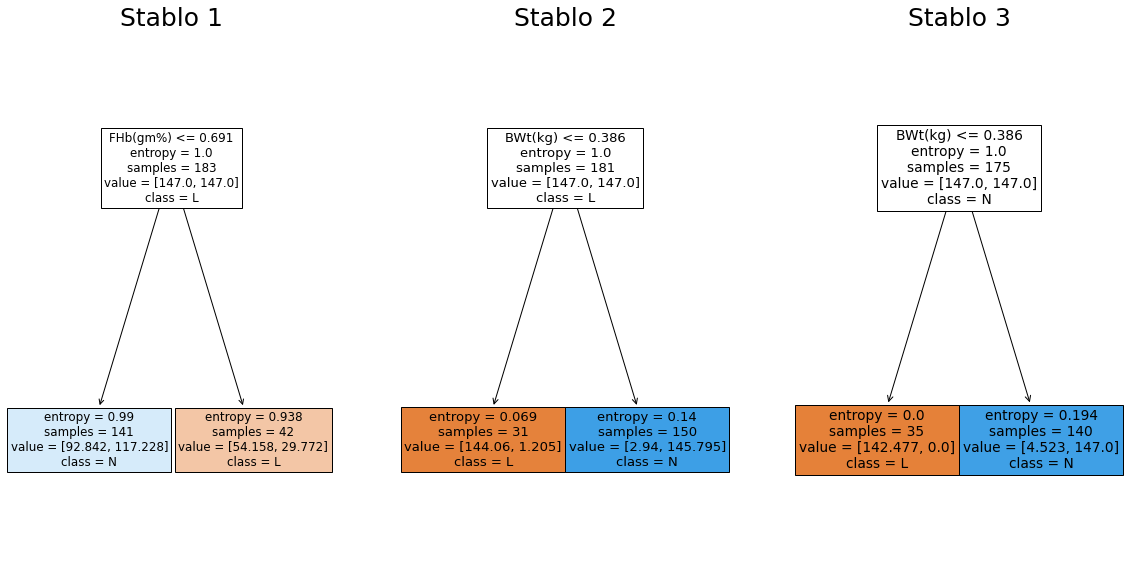

In [496]:
rfc=RandomForestClassifier(n_estimators=3,criterion="entropy",random_state=42,bootstrap=True,max_depth=1,class_weight="balanced_subsample")

test_model(rfc,X_train,y_train,X_test,y_test)

fn=df_filtered.columns
cn=["L","N"]
fig,ax=plt.subplots(1,3,figsize=(20,10))

for i in range(3):
    tree.plot_tree(rfc.estimators_[i],feature_names=fn,class_names=cn,filled = True,ax=ax[i])
    ax[i].set_title('Stablo ' + str(i+1), fontsize = 25)

Znali smo! Dva od tri stabla dijele po istom kriteriju BWt(kg), čak je i granica ista! De facto, to je jedino stablo koje donosi odluku. Dobili smo savršeni klasifikator, baš kao u članku, isključivo na temelju težine bebe.

# Jesu li rezultati članka valjani?

Gornji zaključak upućuje na to da postupak u članku nije dobar. Ako su težinske kategorije bebe L,N,H jednoznačno određene rasponom masa koji se ne preklapaju, iz BWt(kg) jednoznačno se može odrediti izlazna klasa $y$. Pokušajmo pronaći te intervale za klase L i N.

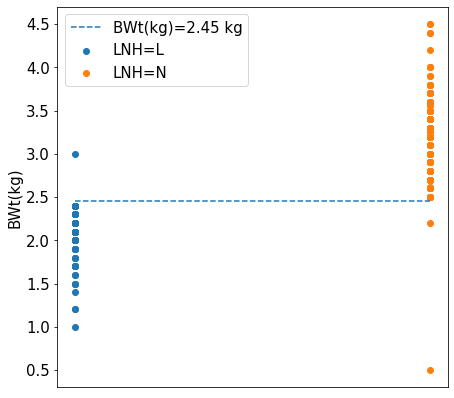

In [498]:
df_filtered=df[df["LNH"].isna()==False]
df_filtered=df_filtered[(df_filtered["LNH"]!=3) & (df_filtered["Sex"]!="T")] 

fig=plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==1])),df_filtered[df_filtered["LNH"]==1]["BWt(kg)"],label="LNH=L")
plt.scatter(np.ones(len(df_filtered[df_filtered["LNH"]==2]))*2,df_filtered[df_filtered["LNH"]==2]["BWt(kg)"],label="LNH=N")
plt.plot([1,2],[2.45,2.45],"--",label="BWt(kg)=2.45 kg")
plt.xticks([])
plt.ylabel("BWt(kg)")
plt.legend()
plt.show()

Vidimo da u skupu podataka čak i ovdje imamo problem! Postoje bebe označene klasom N s manjom masom od beba označenih klasom L i obratno. Još jedan u nizu stvari koje treba popraviti...

#------------------------------------------------------------------NAPRAVLJENO DO OVDI----------------------------------------------------------------------------------------#

Korelacija Bgroup-BWt:
-0.007951927136644148

Korelacija BS-BWt:
0.1656598947145648


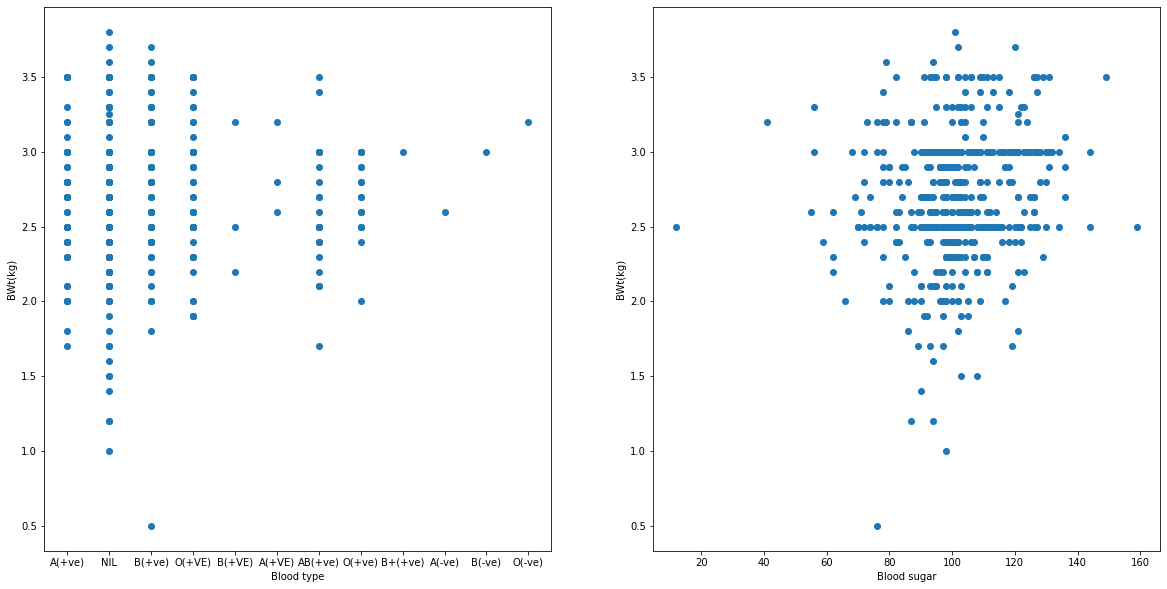

In [260]:
df_bgroup=df_filtered[df_filtered["Bgroup"].isna()==False]


print("Korelacija Bgroup-BWt:")
print(np.corrcoef(df_bgroup["Bgroup"].astype("category").cat.codes,df_bgroup["BWt(kg)"])[0,1])

fig,ax=plt.subplots(1,2,figsize=(20,10))
ax[0].scatter(df_bgroup["Bgroup"],df_bgroup["BWt(kg)"])
ax[0].set_xlabel("Blood type")
ax[0].set_ylabel("BWt(kg)")

df_bs=df_filtered[df_filtered["BS(RBS)"].isna()==False]

print("\nKorelacija BS-BWt:")
print(np.corrcoef(df_bs["BS(RBS)"],df_bs["BWt(kg)"])[0,1])

ax[1].scatter(df_bs["BS(RBS)"],df_bs["BWt(kg)"])
ax[1].set_xlabel("Blood sugar")
ax[1].set_ylabel("BWt(kg)")
plt.show()

In [160]:
np.var(X,axis=0)

array([0.19889782, 0.03187482, 0.02757169, 3.97545647, 0.08975402,
       0.06601158, 0.03040715, 0.03107567, 0.0213896 , 0.03463947,
       0.01842746, 0.03431371, 0.04631739, 0.02781732, 0.02521399,
       0.10240029, 0.24955233, 0.02913417])

In [71]:
svc=SVC(kernel="rbf",gamma=.3,C=1,class_weight="balanced")

test_model(svc,X_train[:,1:-2],y_train,X_test[:,1:-2],y_test)

Train accuracy, precision, recall, F1: 0.530 0.929 0.457 0.613
Test accuracy, precision, recall, F1: 0.511 0.814 0.514 0.630
[[13 13]
 [54 57]]


In [125]:
#def moving_average_categorical(df,columns,window_size):
    for col in columns:
        for i in range(len(df)):
            if pd.isna(df.loc[i, col]):
                start = max(0, i - window_size)
                end = min(len(df), i + window_size + 1)
    
                nearby_values = df[col].iloc[start:end].dropna()

                df.at[i, col] = nearby_values.mode()
                
    return df

#df1=moving_average_categorical(df,["Sex"],3)
#plt.plot(df1["BS(RBS)"])

IndentationError: unexpected indent (2165512536.py, line 2)

In [76]:
knn=KNeighborsClassifier(n_neighbors=1,weights="distance")

test_model(knn,X_train[:,],y_train,X_test[:,:],y_test)

Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.781 0.846 0.892 0.868
[[ 8 18]
 [12 99]]


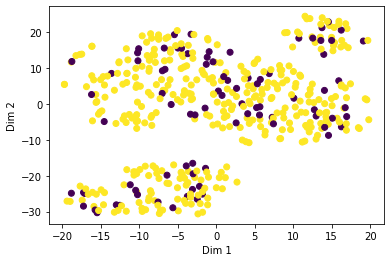

In [113]:
tsne=TSNE(n_components=2,n_iter=1000,perplexity=30,random_state=42)
X_tsne=tsne.fit_transform(X[:,1:-2])

plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()

# LDA

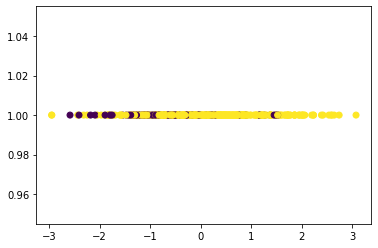

In [112]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda=LDA(n_components=1,solver="svd")

X_lda=lda.fit_transform(X[:,1:-2],y)
plt.scatter(X_lda,np.ones(len(X_lda)),c=y)


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.30, random_state=42, stratify=y)

knn=KNeighborsClassifier(n_neighbors=5,weights="distance")
test_model(knn,X_train[:,],y_train,X_test[:,:],y_test)

Train accuracy, precision, recall, F1: 1.000 1.000 1.000 1.000
Test accuracy, precision, recall, F1: 0.752 0.841 0.856 0.848
[[ 8 18]
 [16 95]]
